In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class
from src.preprocessing.sequence_classification.set_fit_dataset import SetFitDataset
from src.model.sequence_classification.trainer import SequenceClassificationTrainer
import warnings
warnings.filterwarnings("ignore")

In [3]:
notebook_login()

In [4]:
!mkdir logs
model_name = "SetFit"
dataset_name = "AG_news"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
# logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


## SetFit

In [5]:
model = SentenceTransformer("whaleloops/phrase-bert")

KeyboardInterrupt: 

In [6]:
try:
    from torch.hub import _get_torch_home

    torch_cache_home = _get_torch_home()
except ImportError:
    torch_cache_home = os.path.expanduser(os.getenv('TORCH_HOME', os.path.join(os.getenv('XDG_CACHE_HOME', '~/.cache'), 'torch')))

cache_folder = os.path.join(torch_cache_home, 'sentence_transformers')

In [7]:
cache_folder

'/users/eleves-a/2022/pedro.silva/.cache/torch/sentence_transformers'

In [8]:
model

NameError: name 'model' is not defined

## Loading AGnews data

In [9]:
ag_news_dataset = load_dataset("ag_news")

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [10]:
num_classes = len(ag_news_dataset['train']\
    .features['label']\
    .names)

classes_names = ag_news_dataset['train']\
    .features['label']\
    .names

num_classes

4

In [11]:
data_size = len(ag_news_dataset['train'])
data_size

120000

In [12]:
train_text = ag_news_dataset['train']['text'][0:data_size*3//5]
train_labels = ag_news_dataset['train']['label'][0:data_size*3//5]

val_text = ag_news_dataset['train']['text'][data_size*3//5:]
val_labels = ag_news_dataset['train']['label'][data_size*3//5:]

## 2 shots

In [13]:
n_shots =2 

In [14]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)

In [15]:
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 10,
    num_classes=num_classes
)

In [16]:
set_fit_data_train = SetFitDataset(
    X_train,
    y_train, 
    input_example_format= True
    # R = 5
)

set_fit_data_val = SetFitDataset(
    X_val,
    y_val,
    # R = 5,
    input_example_format= False
)

In [17]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=True
)

val_dataloader = DataLoader(
    set_fit_data_val
)

### Train embedding

In [18]:
model = SentenceTransformer("whaleloops/phrase-bert")
loss_fn = losses.CosineSimilarityLoss(model)
cos_sim = torch.nn.CosineSimilarity(dim = 1)

n_epochs = 10
best_f1 = 0
best_model = None

for epoch in range(n_epochs):
    model.fit(
        train_objectives=[ (train_dataloader, loss_fn)],
        epochs = 1,
        show_progress_bar=False
    )

    y_true_val = torch.tensor([],device=device)
    y_pred_val = torch.tensor([],device=device)

    print(f"Running validation after {epoch} epochs")

    for [x1, x2, y] in tqdm(val_dataloader):
        with torch.no_grad():
            v1 = model.encode(x1, convert_to_tensor= True)
            v2 = model.encode(x2, convert_to_tensor= True)

            cos = cos_sim(v1, v2)

            y_pred = round(cos.item())
            y_true = y

            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([y_pred]).to(device)
            ])

            y_true_val = torch.cat([
                y_true_val, 
                torch.tensor([y_true]).to(device)
            ])
            
    f1 = binary_f1_score(
        y_pred_val,
        y_true_val,
    )
    if f1 > best_f1:
        best_f1 = f1
        best_model = deepcopy(model)

    conf_matrix= multiclass_confusion_matrix(
        y_pred_val.to(torch.int64),
        y_true_val.to(torch.int64),
        num_classes=2
    )

    print(f'f1 score: {f1.item()}')
    print(conf_matrix)

best_model.save_to_hub(f"peulsilva/phrase-bert-setfit-{n_shots}shots")

Running validation after 0 epochs


100%|██████████| 780/780 [00:06<00:00, 128.49it/s]


f1 score: 0.48985961079597473
tensor([[296, 304],
        [ 23, 157]], device='cuda:0')
Running validation after 1 epochs


100%|██████████| 780/780 [00:06<00:00, 125.63it/s]


f1 score: 0.4906250238418579
tensor([[297, 303],
        [ 23, 157]], device='cuda:0')
Running validation after 2 epochs


100%|██████████| 780/780 [00:06<00:00, 124.20it/s]


f1 score: 0.4921630024909973
tensor([[299, 301],
        [ 23, 157]], device='cuda:0')
Running validation after 3 epochs


100%|██████████| 780/780 [00:06<00:00, 123.64it/s]


f1 score: 0.4864865243434906
tensor([[304, 296],
        [ 27, 153]], device='cuda:0')
Running validation after 4 epochs


100%|██████████| 780/780 [00:06<00:00, 123.68it/s]


f1 score: 0.49275365471839905
tensor([[312, 288],
        [ 27, 153]], device='cuda:0')
Running validation after 5 epochs


100%|██████████| 780/780 [00:06<00:00, 123.16it/s]


f1 score: 0.4886731207370758
tensor([[313, 287],
        [ 29, 151]], device='cuda:0')
Running validation after 6 epochs


100%|██████████| 780/780 [00:06<00:00, 122.64it/s]


f1 score: 0.4910568594932556
tensor([[316, 284],
        [ 29, 151]], device='cuda:0')
Running validation after 7 epochs


100%|██████████| 780/780 [00:06<00:00, 122.36it/s]


f1 score: 0.49508199095726013
tensor([[321, 279],
        [ 29, 151]], device='cuda:0')
Running validation after 8 epochs


100%|██████████| 780/780 [00:06<00:00, 122.33it/s]


f1 score: 0.4958677887916565
tensor([[325, 275],
        [ 30, 150]], device='cuda:0')
Running validation after 9 epochs


100%|██████████| 780/780 [00:06<00:00, 122.57it/s]


f1 score: 0.5016722679138184
tensor([[332, 268],
        [ 30, 150]], device='cuda:0')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Cloning https://huggingface.

Upload file model.safetensors:   0%|          | 1.00/418M [00:00<?, ?B/s]

To https://huggingface.co/peulsilva/phrase-bert-setfit-2shots
   f20ef01..05fde3d  main -> main

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/peulsilva/phrase-bert-setfit-2shots/commit/05fde3d7f712e14935bbe2c4298ff5fb0da03233'

### Training classifier 

In [19]:
class CLF(torch.nn.Module):
    def __init__(
        self,
        in_features : int,
        out_features : int, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features, 512)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(512, 256)
        self.layer3 = torch.nn.Linear(256, out_features)

    def forward(self, x : torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        return self.layer3(x)
    

In [20]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 100,
    num_classes=num_classes
)

In [21]:
from random import shuffle
def shuffle_two_lists(X, y ):
    X_shuff = []
    y_shuff = []
    index_shuf = list(range(len(X)))
    shuffle(index_shuf)
    for i in index_shuf:
        X_shuff.append(X[i])
        y_shuff.append(y[i])


    return X_shuff, y_shuff

In [22]:
X_train_shuffled , y_train_shuffled = shuffle_two_lists(X_train, y_train)

In [23]:
from IPython.display import clear_output

In [24]:
embedding_model = SentenceTransformer(f"peulsilva/phrase-bert-setfit-{n_shots}shots")\
    .to(device)

in_features = embedding_model.get_sentence_embedding_dimension()
clf = CLF(
    in_features,
    num_classes,
).to(device)


loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    clf.parameters(),
    lr = 1e-5
)

best_model = None
best_f1 = 0
n_epochs = 100

history = []

for epoch in (range(n_epochs)):
    for i in tqdm(range(len(X_train))):
        text = X_train_shuffled[i]
        label = torch.tensor(y_train_shuffled[i])\
            .to(device)

        with torch.no_grad():
            embedding = embedding_model.encode(text, convert_to_tensor=True)

        optimizer.zero_grad()
        output = clf(embedding)
        loss = loss_fn(output, label)


        loss.backward()
        optimizer.step()

    y_true_val = torch.tensor([],device=device)
    y_pred_val = torch.tensor([],device=device)

    for i in range(len(X_val)):
        text = X_val[i]
        label = torch.tensor(y_val[i])\
            .to(device)

        with torch.no_grad():
            embedding = embedding_model.encode(text, convert_to_tensor=True)

            y_pred = clf(embedding)\
                .argmax()
            
            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([y_pred]).to(device)
            ])

            y_true_val = torch.cat([
                y_true_val, 
                torch.tensor([y_val[i]]).to(device)
            ])
            
    f1 = multiclass_f1_score(
        y_pred_val,
        y_true_val,
        num_classes=num_classes
    )
    
    history.append(f1.item())
    if f1 > best_f1:
        best_f1 = f1
        best_model = deepcopy(clf)

    conf_matrix= multiclass_confusion_matrix(
        y_pred_val.to(torch.int64),
        y_true_val.to(torch.int64),
        num_classes=num_classes
    )

    clear_output()
    print(f"---------Epoch: {epoch}-----------")
    print(f'f1 score: {f1.item()}')
    print(conf_matrix)

---------Epoch: 99-----------
f1 score: 0.7749999761581421
tensor([[86,  2,  4,  8],
        [ 5, 90,  0,  5],
        [15,  4, 46, 35],
        [ 4,  2,  6, 88]], device='cuda:0')


In [25]:
best_epoch = 0
for idx, f1 in enumerate(history):
    if f1 == best_f1.item():
        best_epoch = idx

In [26]:
best_epoch

99

Text(0.5, 1.0, 'SetFit training results- AG news - 2 shots')

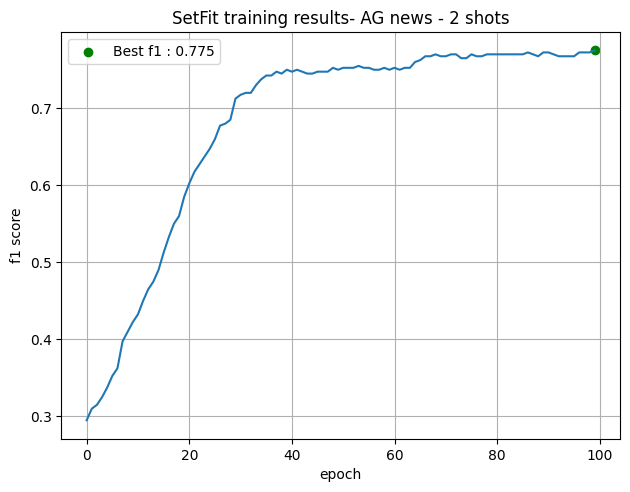

In [27]:
# history = ([k.to('cpu').numpy() for k in history])
plt.plot(history)
plt.scatter(
    [best_epoch], 
    best_f1.item(),
    color = "green",
    label = f"Best f1 : {round(best_f1.item(),3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title("SetFit training results- AG news - 2 shots")

## 5 shots

In [29]:
n_shots = 5

In [30]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)

In [31]:
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 10,
    num_classes=num_classes
)

In [32]:
set_fit_data_train = SetFitDataset(
    X_train,
    y_train, 
    input_example_format= True
    # R = 5
)

set_fit_data_val = SetFitDataset(
    X_val,
    y_val,
    # R = 5,
    input_example_format= False
)

In [33]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=True
)

val_dataloader = DataLoader(
    set_fit_data_val
)

### Train embedding

In [34]:
model = SentenceTransformer("whaleloops/phrase-bert")
loss_fn = losses.CosineSimilarityLoss(model)
cos_sim = torch.nn.CosineSimilarity(dim = 1)

n_epochs = 10
best_f1 = 0
best_model = None

for epoch in range(n_epochs):
    model.fit(
        train_objectives=[ (train_dataloader, loss_fn)],
        epochs = 1,
        show_progress_bar=False
    )

    y_true_val = torch.tensor([],device=device)
    y_pred_val = torch.tensor([],device=device)

    print(f"Running validation after {epoch} epochs")

    for [x1, x2, y] in tqdm(val_dataloader):
        with torch.no_grad():
            v1 = model.encode(x1, convert_to_tensor= True)
            v2 = model.encode(x2, convert_to_tensor= True)

            cos = cos_sim(v1, v2)

            y_pred = round(cos.item())
            y_true = y

            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([y_pred]).to(device)
            ])

            y_true_val = torch.cat([
                y_true_val, 
                torch.tensor([y_true]).to(device)
            ])
            
    f1 = binary_f1_score(
        y_pred_val,
        y_true_val,
    )
    if f1 > best_f1:
        best_f1 = f1
        best_model = deepcopy(model)

    conf_matrix= multiclass_confusion_matrix(
        y_pred_val.to(torch.int64),
        y_true_val.to(torch.int64),
        num_classes=2
    )

    print(f'f1 score: {f1.item()}')
    print(conf_matrix)

best_model.save_to_hub(f"peulsilva/phrase-bert-setfit-{n_shots}shots")

Running validation after 0 epochs


100%|██████████| 780/780 [00:06<00:00, 124.21it/s]


f1 score: 0.5379877090454102
tensor([[424, 176],
        [ 49, 131]], device='cuda:0')
Running validation after 1 epochs


100%|██████████| 780/780 [00:06<00:00, 122.78it/s]


f1 score: 0.5633074045181274
tensor([[502,  98],
        [ 71, 109]], device='cuda:0')
Running validation after 2 epochs


100%|██████████| 780/780 [00:06<00:00, 120.94it/s]


f1 score: 0.5476922392845154
tensor([[544,  56],
        [ 91,  89]], device='cuda:0')
Running validation after 3 epochs


100%|██████████| 780/780 [00:06<00:00, 121.24it/s]


f1 score: 0.4863014221191406
tensor([[559,  41],
        [109,  71]], device='cuda:0')
Running validation after 4 epochs


100%|██████████| 780/780 [00:06<00:00, 120.53it/s]


f1 score: 0.4637681245803833
tensor([[568,  32],
        [116,  64]], device='cuda:0')
Running validation after 5 epochs


100%|██████████| 780/780 [00:06<00:00, 120.56it/s]


f1 score: 0.42424240708351135
tensor([[572,  28],
        [124,  56]], device='cuda:0')
Running validation after 6 epochs


100%|██████████| 780/780 [00:06<00:00, 120.14it/s]


f1 score: 0.41698843240737915
tensor([[575,  25],
        [126,  54]], device='cuda:0')
Running validation after 7 epochs


100%|██████████| 780/780 [00:06<00:00, 121.05it/s]


f1 score: 0.40316203236579895
tensor([[578,  22],
        [129,  51]], device='cuda:0')
Running validation after 8 epochs


100%|██████████| 780/780 [00:06<00:00, 119.71it/s]


f1 score: 0.39840638637542725
tensor([[579,  21],
        [130,  50]], device='cuda:0')
Running validation after 9 epochs


100%|██████████| 780/780 [00:06<00:00, 120.61it/s]


f1 score: 0.3852458894252777
tensor([[583,  17],
        [133,  47]], device='cuda:0')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Cloning https://huggingface.

Upload file model.safetensors:   0%|          | 1.00/418M [00:00<?, ?B/s]

To https://huggingface.co/peulsilva/phrase-bert-setfit-5shots
   41426b9..89e647c  main -> main

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/peulsilva/phrase-bert-setfit-5shots/commit/89e647cccf0032a48572d2f1230671428d8ba0d7'

### Training classifier 

In [35]:
class CLF(torch.nn.Module):
    def __init__(
        self,
        in_features : int,
        out_features : int, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features, 512)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(512, 256)
        self.layer3 = torch.nn.Linear(256, out_features)

    def forward(self, x : torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        return self.layer3(x)
    

In [36]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 100,
    num_classes=num_classes
)

In [37]:
from random import shuffle
def shuffle_two_lists(X, y ):
    X_shuff = []
    y_shuff = []
    index_shuf = list(range(len(X)))
    shuffle(index_shuf)
    for i in index_shuf:
        X_shuff.append(X[i])
        y_shuff.append(y[i])


    return X_shuff, y_shuff

In [38]:
X_train_shuffled , y_train_shuffled = shuffle_two_lists(X_train, y_train)

In [39]:
from IPython.display import clear_output

In [40]:
embedding_model = SentenceTransformer(f"peulsilva/phrase-bert-setfit-{n_shots}shots")\
    .to(device)

in_features = embedding_model.get_sentence_embedding_dimension()
clf = CLF(
    in_features,
    num_classes,
).to(device)


loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    clf.parameters(),
    lr = 1e-5
)

best_model = None
best_f1 = 0
n_epochs = 100

history = []

for epoch in (range(n_epochs)):
    for i in tqdm(range(len(X_train))):
        text = X_train_shuffled[i]
        label = torch.tensor(y_train_shuffled[i])\
            .to(device)

        with torch.no_grad():
            embedding = embedding_model.encode(text, convert_to_tensor=True)

        optimizer.zero_grad()
        output = clf(embedding)
        loss = loss_fn(output, label)


        loss.backward()
        optimizer.step()

    y_true_val = torch.tensor([],device=device)
    y_pred_val = torch.tensor([],device=device)

    for i in range(len(X_val)):
        text = X_val[i]
        label = torch.tensor(y_val[i])\
            .to(device)

        with torch.no_grad():
            embedding = embedding_model.encode(text, convert_to_tensor=True)

            y_pred = clf(embedding)\
                .argmax()
            
            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([y_pred]).to(device)
            ])

            y_true_val = torch.cat([
                y_true_val, 
                torch.tensor([y_val[i]]).to(device)
            ])
            
    f1 = multiclass_f1_score(
        y_pred_val,
        y_true_val,
        num_classes=num_classes
    )
    
    history.append(f1.item())
    if f1 > best_f1:
        best_f1 = f1
        best_model = deepcopy(clf)

    conf_matrix= multiclass_confusion_matrix(
        y_pred_val.to(torch.int64),
        y_true_val.to(torch.int64),
        num_classes=num_classes
    )

    clear_output()
    print(f"---------Epoch: {epoch}-----------")
    print(f'f1 score: {f1.item()}')
    print(conf_matrix)

---------Epoch: 99-----------
f1 score: 0.7225000262260437
tensor([[72,  1, 18,  9],
        [ 5, 86,  1,  8],
        [ 2,  1, 44, 53],
        [ 1,  0, 12, 87]], device='cuda:0')


In [41]:
best_epoch = 0
for idx, f1 in enumerate(history):
    if f1 == best_f1.item():
        best_epoch = idx

In [42]:
best_epoch

18

Text(0.5, 1.0, 'SetFit training results- AG news - 5 shots')

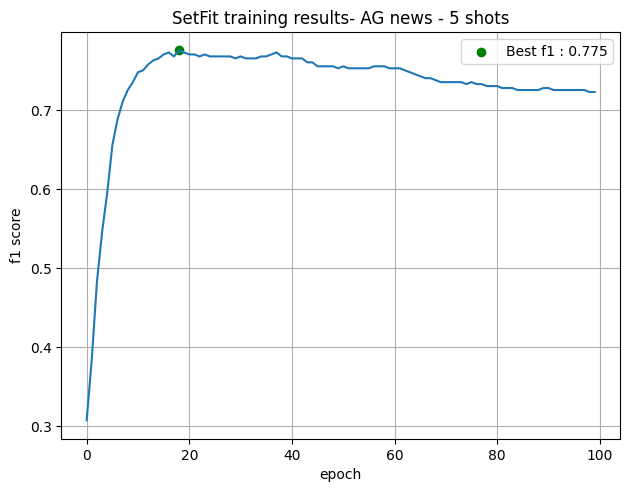

In [43]:
# history = ([k.to('cpu').numpy() for k in history])
plt.plot(history)
plt.scatter(
    [best_epoch], 
    best_f1.item(),
    color = "green",
    label = f"Best f1 : {round(best_f1.item(),3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title("SetFit training results- AG news - 5 shots")

## 10 shots

In [44]:
n_shots = 10

In [45]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)

In [46]:
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 10,
    num_classes=num_classes
)

In [47]:
set_fit_data_train = SetFitDataset(
    X_train,
    y_train, 
    input_example_format= True
    # R = 5
)

set_fit_data_val = SetFitDataset(
    X_val,
    y_val,
    # R = 5,
    input_example_format= False
)

In [48]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=True
)

val_dataloader = DataLoader(
    set_fit_data_val
)

### Train embedding

In [49]:
model = SentenceTransformer("whaleloops/phrase-bert")
loss_fn = losses.CosineSimilarityLoss(model)
cos_sim = torch.nn.CosineSimilarity(dim = 1)

n_epochs = 10
best_f1 = 0
best_model = None

for epoch in range(n_epochs):
    model.fit(
        train_objectives=[ (train_dataloader, loss_fn)],
        epochs = 1,
        show_progress_bar=False
    )

    y_true_val = torch.tensor([],device=device)
    y_pred_val = torch.tensor([],device=device)

    print(f"Running validation after {epoch} epochs")

    for [x1, x2, y] in tqdm(val_dataloader):
        with torch.no_grad():
            v1 = model.encode(x1, convert_to_tensor= True)
            v2 = model.encode(x2, convert_to_tensor= True)

            cos = cos_sim(v1, v2)

            y_pred = round(cos.item())
            y_true = y

            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([y_pred]).to(device)
            ])

            y_true_val = torch.cat([
                y_true_val, 
                torch.tensor([y_true]).to(device)
            ])
            
    f1 = binary_f1_score(
        y_pred_val,
        y_true_val,
    )
    if f1 > best_f1:
        best_f1 = f1
        best_model = deepcopy(model)

    conf_matrix= multiclass_confusion_matrix(
        y_pred_val.to(torch.int64),
        y_true_val.to(torch.int64),
        num_classes=2
    )

    print(f'f1 score: {f1.item()}')
    print(conf_matrix)

best_model.save_to_hub(f"peulsilva/phrase-bert-setfit-{n_shots}shots")

Running validation after 0 epochs


100%|██████████| 780/780 [00:06<00:00, 123.46it/s]


f1 score: 0.3613445460796356
tensor([[585,  15],
        [137,  43]], device='cuda:0')
Running validation after 1 epochs


100%|██████████| 780/780 [00:06<00:00, 121.27it/s]


f1 score: 0.540145993232727
tensor([[580,  20],
        [106,  74]], device='cuda:0')
Running validation after 2 epochs


100%|██████████| 780/780 [00:06<00:00, 121.03it/s]


f1 score: 0.6538461446762085
tensor([[570,  30],
        [ 78, 102]], device='cuda:0')
Running validation after 3 epochs


100%|██████████| 780/780 [00:06<00:00, 121.03it/s]


f1 score: 0.650306761264801
tensor([[560,  40],
        [ 74, 106]], device='cuda:0')
Running validation after 4 epochs


100%|██████████| 780/780 [00:06<00:00, 121.45it/s]


f1 score: 0.6726190447807312
tensor([[557,  43],
        [ 67, 113]], device='cuda:0')
Running validation after 5 epochs


100%|██████████| 780/780 [00:06<00:00, 120.47it/s]


f1 score: 0.6882352828979492
tensor([[557,  43],
        [ 63, 117]], device='cuda:0')
Running validation after 6 epochs


100%|██████████| 780/780 [00:06<00:00, 121.36it/s]


f1 score: 0.7005649209022522
tensor([[550,  50],
        [ 56, 124]], device='cuda:0')
Running validation after 7 epochs


100%|██████████| 780/780 [00:06<00:00, 120.38it/s]


f1 score: 0.7122506499290466
tensor([[554,  46],
        [ 55, 125]], device='cuda:0')
Running validation after 8 epochs


100%|██████████| 780/780 [00:06<00:00, 120.14it/s]


f1 score: 0.7048709988594055
tensor([[554,  46],
        [ 57, 123]], device='cuda:0')
Running validation after 9 epochs


100%|██████████| 780/780 [00:06<00:00, 120.66it/s]


f1 score: 0.7106016874313354
tensor([[555,  45],
        [ 56, 124]], device='cuda:0')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Cloning https://huggingface.

Upload file model.safetensors:   0%|          | 1.00/418M [00:00<?, ?B/s]

To https://huggingface.co/peulsilva/phrase-bert-setfit-10shots
   7950fac..b2f78f7  main -> main

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/peulsilva/phrase-bert-setfit-10shots/commit/b2f78f7d3505a75fe122586bf722a7c605b1eddd'

### Training classifier 

In [50]:
class CLF(torch.nn.Module):
    def __init__(
        self,
        in_features : int,
        out_features : int, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features, 512)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(512, 256)
        self.layer3 = torch.nn.Linear(256, out_features)

    def forward(self, x : torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        return self.layer3(x)
    

In [51]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 100,
    num_classes=num_classes
)

In [52]:
from random import shuffle
def shuffle_two_lists(X, y ):
    X_shuff = []
    y_shuff = []
    index_shuf = list(range(len(X)))
    shuffle(index_shuf)
    for i in index_shuf:
        X_shuff.append(X[i])
        y_shuff.append(y[i])


    return X_shuff, y_shuff

In [53]:
X_train_shuffled , y_train_shuffled = shuffle_two_lists(X_train, y_train)

In [54]:
from IPython.display import clear_output

In [59]:
embedding_model = SentenceTransformer(f"peulsilva/phrase-bert-setfit-{n_shots}shots")\
    .to(device)

in_features = embedding_model.get_sentence_embedding_dimension()
clf = CLF(
    in_features,
    num_classes,
).to(device)


loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    clf.parameters(),
    lr = 1e-5
)

best_model = None
best_f1 = 0
n_epochs = 100

history = []

for epoch in (range(n_epochs)):
    for i in tqdm(range(len(X_train))):
        text = X_train_shuffled[i]
        label = torch.tensor(y_train_shuffled[i])\
            .to(device)

        with torch.no_grad():
            embedding = embedding_model.encode(text, convert_to_tensor=True)

        optimizer.zero_grad()
        output = clf(embedding)
        loss = loss_fn(output, label)


        loss.backward()
        optimizer.step()

    y_true_val = torch.tensor([],device=device)
    y_pred_val = torch.tensor([],device=device)

    for i in range(len(X_val)):
        text = X_val[i]
        label = torch.tensor(y_val[i])\
            .to(device)

        with torch.no_grad():
            embedding = embedding_model.encode(text, convert_to_tensor=True)

            y_pred = clf(embedding)\
                .argmax()
            
            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([y_pred]).to(device)
            ])

            y_true_val = torch.cat([
                y_true_val, 
                torch.tensor([y_val[i]]).to(device)
            ])
            
    f1 = multiclass_f1_score(
        y_pred_val,
        y_true_val,
        num_classes=num_classes
    )
    
    history.append(f1.item())
    if f1 > best_f1:
        best_f1 = f1
        best_model = deepcopy(clf)

    conf_matrix= multiclass_confusion_matrix(
        y_pred_val.to(torch.int64),
        y_true_val.to(torch.int64),
        num_classes=num_classes
    )

    clear_output()
    print(f"---------Epoch: {epoch}-----------")
    print(f'f1 score: {f1.item()}')
    print(conf_matrix)

---------Epoch: 52-----------
f1 score: 0.8475000262260437
tensor([[85,  1, 12,  2],
        [12, 86,  1,  1],
        [ 3,  0, 82, 15],
        [ 6,  0,  8, 86]], device='cuda:0')


100%|██████████| 40/40 [00:00<00:00, 216.17it/s]


KeyboardInterrupt: 

In [56]:
best_epoch = 0
for idx, f1 in enumerate(history):
    if f1 == best_f1.item():
        best_epoch = idx

In [57]:
best_epoch

11

Text(0.5, 1.0, 'SetFit training results- AG news - 10 shots')

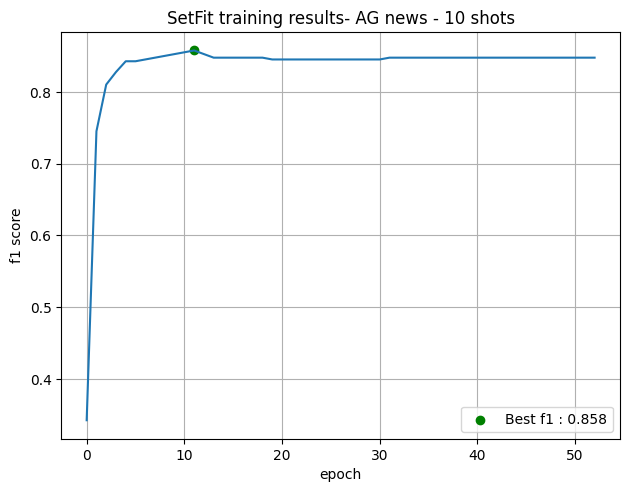

In [61]:
# history = ([k.to('cpu').numpy() for k in history])
plt.plot(history)
plt.scatter(
    [best_epoch], 
    best_f1.item(),
    color = "green",
    label = f"Best f1 : {round(best_f1.item(),3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title("SetFit training results- AG news - 10 shots")

## Analysis

In [13]:
model = SentenceTransformer(
    "peulsilva/phrase-bert-setfit-10shots"
)

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.82k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [14]:
from sklearn.decomposition import PCA

In [ ]:
X, y = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)